In [416]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [417]:
def torch_randnorm(size, dim=0):
    # Generate a random tensor
    rand_tensor = torch.rand(size)
    
    # Normalize along the specified dimension
    sum_along_dim = torch.sum(rand_tensor, dim=dim, keepdim=True)
    normalized_tensor = rand_tensor / sum_along_dim
    
    return normalized_tensor

# Example usage
normalized_tensor = torch_randnorm([5,6], dim=1)
print(normalized_tensor)
print(normalized_tensor.sum(dim=1))

tensor([[0.1511, 0.0118, 0.1806, 0.1962, 0.2192, 0.2411],
        [0.3608, 0.1041, 0.2355, 0.1255, 0.0783, 0.0959],
        [0.3579, 0.2822, 0.0257, 0.1810, 0.1101, 0.0431],
        [0.2259, 0.2166, 0.1719, 0.0780, 0.1517, 0.1558],
        [0.2165, 0.0149, 0.2636, 0.0162, 0.0530, 0.4358]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [418]:
class InteractionModule(nn.Module):
    def __init__(self, n_features):
        super(InteractionModule, self).__init__()
        self.n_features = n_features
        # Initialize a set of interaction tensors, one for the state tensor and one for each column of the transition tensor
        #self.interaction_tensors = nn.ParameterList([nn.Parameter(torch_randnorm([n_features, n_features, n_features], dim = 0)) for _ in range(n_features + 1)])
        self.interaction_tensors = ([(torch_randnorm([n_features, n_features, n_features], dim = 0)) for _ in range(n_features + 1)])

    def forward(self, state_tensor, previous_transition_tensor):
        # Get batch size
        batch = state_tensor.shape[0]
        # Assuming previous_transition_tensors is a list of transition tensors from the previous step
        candidates = []
        for i in range(self.n_features + 1):
            if i == 0:  # Interaction with the state tensor
                current_tensor = state_tensor
            else:  # Interaction with columns of the previous transition tensor
                current_tensor = previous_transition_tensor[:, :, i - 1]

            interaction_tensor = self.interaction_tensors[i]
            current_tensor_expanded = current_tensor.unsqueeze(1).expand(-1, self.n_features, -1)  # Shape: [batch, n_features, n_features]
            interaction_tensor_expanded = interaction_tensor.unsqueeze(0).expand(batch, -1, -1, -1)  # Shape: [batch, n_features, n_features, n_features]
            # Multiply and sum over the last dimension to get the transition tensor
            candidate = torch.einsum('bik,bijk->bij', current_tensor_expanded, interaction_tensor_expanded)
            
            candidates.append(candidate)
            
        candidates_tensor = torch.stack(candidates, dim = -1)
        return candidates_tensor
    
    


In [419]:
class SelectorModule(nn.Module):
    def __init__(self, num_slices):
        super(SelectorModule, self).__init__()
        # A simple linear layer to compute importance scores for each slice
        self.importance = nn.Linear(num_slices, num_slices)

    def forward(self, x, temperature=1):
        # Assuming x is of shape [batch_size, height, width, num_slices]
        batch_size, _, _, num_slices = x.shape

        # Compute importance scores by reducing x across spatial dimensions
        # Here, we take the mean of x across the spatial dimensions to get a vector per slice
        x_reduced = x.mean(dim=[1, 2])  # Shape: [batch_size, num_slices]

        # Compute scores for each slice
        scores = self.importance(x_reduced)  # Shape: [batch_size, num_slices]
        
        # Apply Gumbel-Softmax to approximate a discrete selection of slices
        weights = F.gumbel_softmax(scores, tau=temperature, hard=False, dim=-1)
        #weights = torch.softmax(scores,dim=-1)
        #print(weights)
        # Correct application of weights:
        # We need to ensure weights are applied across the num_slices dimension correctly.
        # Since weights are [batch_size, num_slices] and x is [batch_size, height, width, num_slices],
        # we permute x to bring num_slices to the front for broadcasting.
        x_permuted = x.permute(0, 3, 1, 2)  # Shape: [batch_size, num_slices, height, width]
        
        # Now, multiply by weights. We need to reshape weights to [batch_size, num_slices, 1, 1] for broadcasting.
        weighted_slices = x_permuted * weights.view(batch_size, num_slices, 1, 1)
        
        # Finally, sum the weighted slices across the num_slices dimension (now the first dimension after permute)
        selected = weighted_slices.sum(dim=1)  # Shape: [batch_size, height, width]\
            
        selected = x[:, :, :, 0]

        return selected

# Example usage
batch_size = 10
tensor = torch.rand(batch_size, 5, 5, 6)  # Example tensor
model = SelectorModule(num_slices=6)

result = model(tensor)
print(result.shape)  # Should print torch.Size([10, 5, 5])

torch.Size([10, 5, 5])


In [420]:
class NeuralCoilLayer(nn.Module):
    def __init__(self, n_features):
        super(NeuralCoilLayer, self).__init__()
        self.n_features = n_features
        self.interaction_module = InteractionModule(n_features)
        self.selector_module = SelectorModule(n_features + 1)
        
    def step_coil(self, state_tensor, previous_transition_tensor):
        # Generate candidates
        candidates = self.interaction_module(state_tensor, previous_transition_tensor)
        # Select one candidate
        selected_transition_tensor = self.selector_module(candidates)
        
        new_state_tensor = torch.matmul(selected_transition_tensor, state_tensor.unsqueeze(-1)).squeeze(-1)
        
        return new_state_tensor, selected_transition_tensor

    def forward(self, x):
        batch, length, n_features = x.size()
        output = x.new_empty(batch, length, n_features)

        # Initialize previous transition tensors (for the first step)
        # Assuming it's a list of zero tensors for simplicity
        transition_tensor = torch.zeros(batch, n_features, n_features)

        for l in range(length):
            state_tensor = x[:, l, :]
            
            # Compute output for this step
            output[:, l, :], transition_tensor = self.step_coil(state_tensor, transition_tensor)

        return output, transition_tensor


# Sequence-to-Sequence Check

In [421]:
n_features = 16
batch, length, dim = 13, 64, n_features
x = torch.randn(batch, length, dim)
model = NeuralCoilLayer(
    n_features = n_features
)
y = model(x)

print(y[0].shape)
assert y[0].shape == x.shape

torch.Size([13, 64, 16])


## Consistency Check

In [422]:
n_features = 4
batch, length, dim = 13, 64, n_features
x =torch_randnorm([batch, length, dim], dim = 2)
model = NeuralCoilLayer(
    n_features = n_features
)

l = 1
state_tensor = x[:, l, :]
print(state_tensor[1,:])
transition_tensor = torch_randnorm([batch, n_features, n_features], dim = 1)
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
print(new_state[1,:])

tensor([0.2620, 0.2170, 0.2895, 0.2314])
tensor([0.2610, 0.2556, 0.2522, 0.2312])
tensor([0.2610, 0.2556, 0.2522, 0.2312])


This should be the same as if we just look at the batches independently

In [423]:
batch = 2
transition_tensor = torch_randnorm([batch, n_features, n_features], dim = 2)
l = 1
state_tensor = x[0:2, l, :]
new_state, new_transition_tensor = model.step_coil(state_tensor, transition_tensor)
new_state[1,:]

tensor([0.2610, 0.2556, 0.2522, 0.2312])

In [424]:
states = []
for step_state in range(100):
    print(torch.sum(transition_tensor, dim = 0))
    state_tensor, transition_tensor = model.step_coil(state_tensor, transition_tensor)
    states.append(state_tensor)

tensor([[0.5213, 0.3246, 0.4225, 0.7317],
        [0.4711, 0.4596, 0.5962, 0.4731],
        [0.4096, 0.4524, 0.8554, 0.2825],
        [0.6242, 0.5198, 0.5960, 0.2600]])
tensor([[0.6279, 0.5203, 0.4417, 0.6474],
        [0.4069, 0.1855, 0.7908, 0.5261],
        [0.5274, 0.7637, 0.4058, 0.3518],
        [0.4378, 0.5306, 0.3616, 0.4747]])
tensor([[0.6465, 0.4635, 0.4221, 0.5810],
        [0.3844, 0.1932, 0.7799, 0.5995],
        [0.5152, 0.7778, 0.3858, 0.3864],
        [0.4539, 0.5654, 0.4121, 0.4332]])
tensor([[0.6497, 0.4557, 0.4170, 0.5736],
        [0.3792, 0.1932, 0.7824, 0.6045],
        [0.5138, 0.7834, 0.3828, 0.3911],
        [0.4572, 0.5677, 0.4178, 0.4307]])
tensor([[0.6504, 0.4542, 0.4173, 0.5739],
        [0.3788, 0.1937, 0.7819, 0.6035],
        [0.5143, 0.7841, 0.3822, 0.3918],
        [0.4565, 0.5680, 0.4186, 0.4308]])
tensor([[0.6503, 0.4544, 0.4171, 0.5738],
        [0.3788, 0.1936, 0.7822, 0.6035],
        [0.5142, 0.7841, 0.3822, 0.3917],
        [0.4567, 0.5679, 0.41

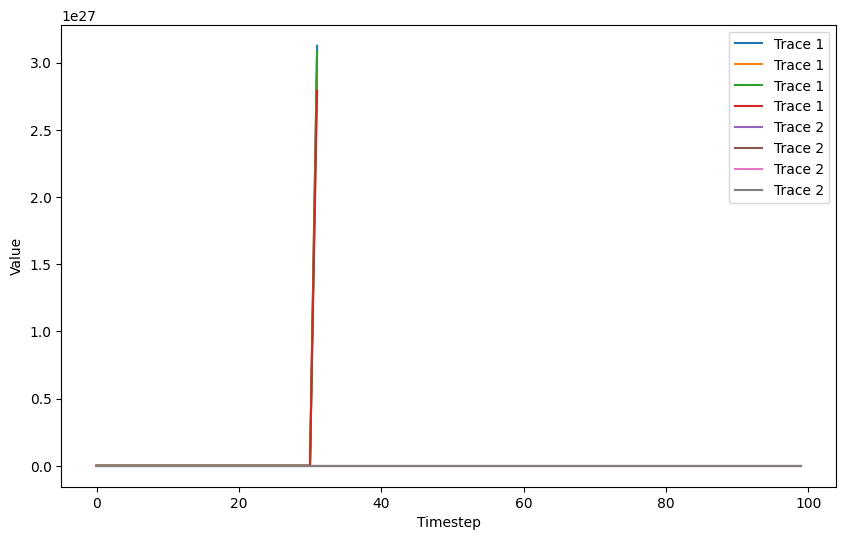

In [425]:
import matplotlib.pyplot as plt

# Your data
data = [row.to('cpu').detach().numpy() for row in states]
# Transpose the data to get 5 traces
traces = list(zip(*data))

# Plotting
plt.figure(figsize=(10, 6))
for i, trace in enumerate(traces):
    plt.plot(trace, label=f'Trace {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Value')
plt.legend()
plt.show()

If this isn't the same, something is wrong with this development. This is fine, so the issue was in gumbel.softmax

# Normalization Checks

In [426]:
interaction_tensors = [torch_randnorm([n_features, n_features, n_features], dim = 0) for _ in range(n_features + 1)]
state_tensor = torch_randnorm([n_features], dim = 0)

for itime in range(4):
    for interaction_tensor in interaction_tensors:
        transition_tensor_candidate = torch.matmul(interaction_tensor, state_tensor)
        new_state_tensor = torch.matmul(transition_tensor_candidate,state_tensor)
        print(torch.sum(state_tensor))
        print(torch.sum(transition_tensor_candidate,dim = 0))
        print(torch.sum(new_state_tensor))
        state_tensor = new_state_tensor
        transition_tensor = transition_tensor_candidate


tensor(1.)
tensor([1., 1., 1., 1.])
tensor(1.)
tensor(1.)
tensor([1., 1., 1., 1.])
tensor(1.)
tensor(1.)
tensor([1., 1., 1., 1.])
tensor(1.)
tensor(1.)
tensor([1., 1., 1., 1.])
tensor(1.)
tensor(1.)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(1.0000)
tensor(1.0000)
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor(0.9999)
tensor(0.9999)
tensor([0.9999, 0.99